# Sample data from Raster

The goal of this notebook is to:  
1. Calculate centroid of landslide polygons  
2. Create buffer based on polygon bounds  
3. Sample raster Stat data from DEM
4. Merge to existing data frame

-- Please note that this notebook uses ChatGPT inspired code for some processes <br>

### Miscelaneous preparation

In [1]:
# Connect to google drive data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install rasterio

In [3]:
!pip install rasterstats

In [4]:
# Import libraries - vector data
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
import re
from shapely.wkt import dumps
import numpy as np

# Import libraries - Raster
import rasterio as rio
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
import os
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

In [5]:
# Miscelaneous processes

# Path to the shapefile containing the landslide inventory
main_path = '/content/drive/MyDrive/MLGeo23_Landslide_FinalProject/data'

# open study area
study_area = gpd.read_file(main_path + '/study_area/king_county_sf.shp')

# open complete inventory
gdf = gpd.read_file(main_path + '/inventory/inventory_gdf.gpkg')

## 1. Sample DEM

In [ ]:
# open raster DEM and clip
raster_path = main_path + '/elevation/30m_wa_DEM_reproj.tif'
src = rio.open(raster_path)

# define geometry of reference
geom = study_area.geometry

# Getting extent of masked raster array
ls_extent = rio.plot.plotting_extent(src)

# clip for KC study area
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(src, geom, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

In [ ]:
# Geometry area and centroid // Adding columns
gdf['centroid'] = gdf.geometry.centroid
centroid = gdf['centroid']

#define buffer
buff_dist = src.res[0]*3

# create new geodataframe
centroid_buff = centroid.buffer(buff_dist)

centroid_buff_gdf = gpd.GeoDataFrame(centroid.copy(), geometry=centroid_buff)

''' Rio sample to extract single values '''

# # Comprehensive list for rio sampling
# rio_xy = [(pt.x, pt.y) for pt in centroid.geometry]
# rio_sample = np.fromiter(src.sample(rio_xy), dtype=ma.dtype)

# # dealing with nodata
# rio_sample = rio_sample.astype(float)
# rio_sample[rio_sample == src.nodata] = np.nan

# # storing sample data
# gdf['elevation'] = rio_sample

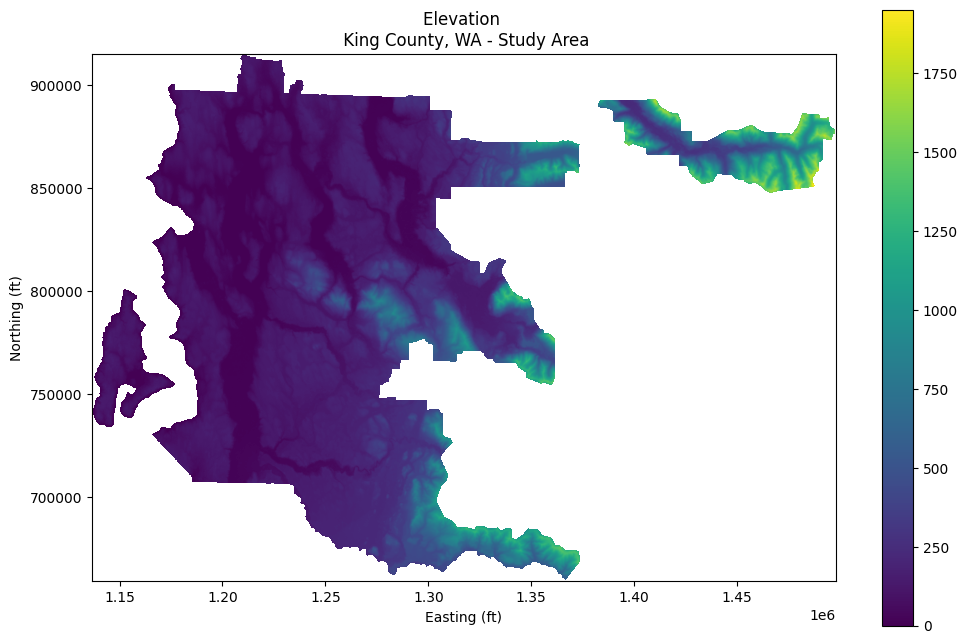

In [ ]:
# Sanity check using or_ma
f, ax = plt.subplots(figsize=(12,8))
map = ax.imshow(ma, extent=ma_extent, cmap = 'viridis')
plt.title('Elevation \n King County, WA - Study Area')
plt.xlabel('Easting (ft)')
plt.ylabel('Northing (ft)')
f.colorbar(map, ax=ax);

### Calculate Centroid of Landslides

In [ ]:
# Define relevant stats for our sampling
stats = ['min', 'max', 'mean', 'std']

# rasterstats
gdf_zonal_stats = rasterstats.zonal_stats(centroid_buff_gdf, ma, affine = ma_transform, nodata=src.nodata, stats=stats)

In [ ]:
# sanity check fpr zonal stats
gdf_zonal_stats[0:5]

[{'min': 42.0,
  'max': 78.0,
  'mean': 64.46428571428571,
  'std': 11.004811100011612},
 {'min': 21.0,
  'max': 70.0,
  'mean': 46.607142857142854,
  'std': 14.056872456748907},
 {'min': 43.0,
  'max': 80.0,
  'mean': 64.41379310344827,
  'std': 11.366973458769323},
 {'min': 44.0,
  'max': 84.0,
  'mean': 66.14285714285714,
  'std': 11.624218209393346},
 {'min': 38.0,
  'max': 75.0,
  'mean': 62.370370370370374,
  'std': 9.047807789113985}]

In [ ]:
# creating a DataFrame to store values in the original inventory data
zonal_stats_df = pd.DataFrame(gdf_zonal_stats, index = centroid_buff_gdf.index)
zonal_stats_df.head()
print(zonal_stats_df.shape)

(2670, 4)


In [ ]:
# join two dataframes
gdf_concat = gdf.copy()
gdf_concat = pd.concat([gdf_concat, zonal_stats_df], axis=1)
# sanity check
gdf_concat.head()

,OBJECTID,soruce_length,source_area,landslide_ID,deposit_area,CONFIDENCE,MATERIAL,SLOPE_DEG,HS_HEIGHT,FAIL_DEPTH,VOLUME_FT3,geometry,centroid,min,max,mean,std
0,1,3851.588931,147260.070502,5600,531934.562792,moderate,Earth or debris,31,72,62,3.297994e+07,"POLYGON ((1175895.407 901572.922, 1175950.408 ...",POINT (1176081.331 900702.237),42.0,78.0,64.464286,11.004811
1,2,478.577643,7375.893616,5601,13973.308516,low,Earth or debris,31,40,34,4.750925e+05,"POLYGON ((1175850.769 899952.492, 1175859.171 ...",POINT (1175912.121 899921.581),21.0,70.0,46.607143,14.056872
2,3,621.878585,9097.112403,5602,25699.961862,low,Earth or debris,28,28,25,6.424990e+05,"POLYGON ((1175964.686 899854.428, 1175984.870 ...",POINT (1176079.769 899857.321),43.0,80.0,64.413793,11.366973
3,4,1187.857110,20648.173693,5603,94054.007176,low,Earth or debris,32,45,38,3.574052e+06,"POLYGON ((1175963.168 899470.295, 1175991.438 ...",POINT (1175979.236 899483.659),44.0,84.0,66.142857,11.624218
4,5,1866.133373,35616.221508,5604,90517.371084,moderate,Earth or debris,32,33,28,2.534486e+06,"POLYGON ((1175870.173 899170.666, 1175868.971 ...",POINT (1175842.134 899240.070),38.0,75.0,62.370370,9.047808


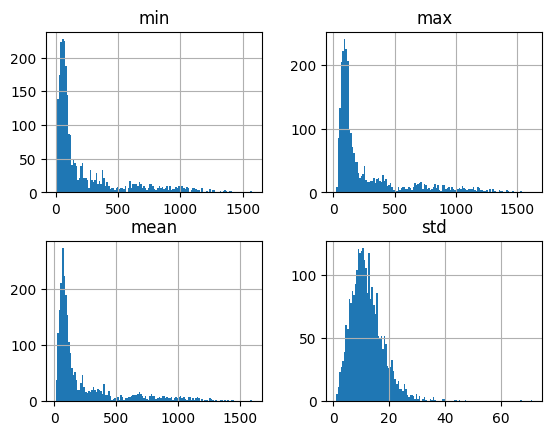

In [ ]:
gdf_concat[['min','max', 'mean', 'std']].hist(bins=128);

In [ ]:
# changing names for better practices:
gdf_concat = gdf_concat.rename(columns={'min':'min_elev', 'max':'max_elev', 'mean':'mean_elev', 'std':'std_elev'})

# last sanity check of the dataframe:
gdf_concat.head(2)

,OBJECTID,soruce_length,source_area,landslide_ID,deposit_area,CONFIDENCE,MATERIAL,SLOPE_DEG,HS_HEIGHT,FAIL_DEPTH,VOLUME_FT3,geometry,centroid,min_elev,max_elev,mean_elev,std_elev
0,1,3851.588931,147260.070502,5600,531934.562792,moderate,Earth or debris,31,72,62,3.297994e+07,"POLYGON ((1175895.407 901572.922, 1175950.408 ...",POINT (1176081.331 900702.237),42.0,78.0,64.464286,11.004811
1,2,478.577643,7375.893616,5601,13973.308516,low,Earth or debris,31,40,34,4.750925e+05,"POLYGON ((1175850.769 899952.492, 1175859.171 ...",POINT (1175912.121 899921.581),21.0,70.0,46.607143,14.056872


## 2. Sample Roughness

In [ ]:
# open raster and clip
raster_path = main_path + '/roughness_wa/wa_roughness_reproj.tif' # change the path
src = rio.open(raster_path)

# clip for KC study area
geom = study_area.geometry
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(src, geom, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

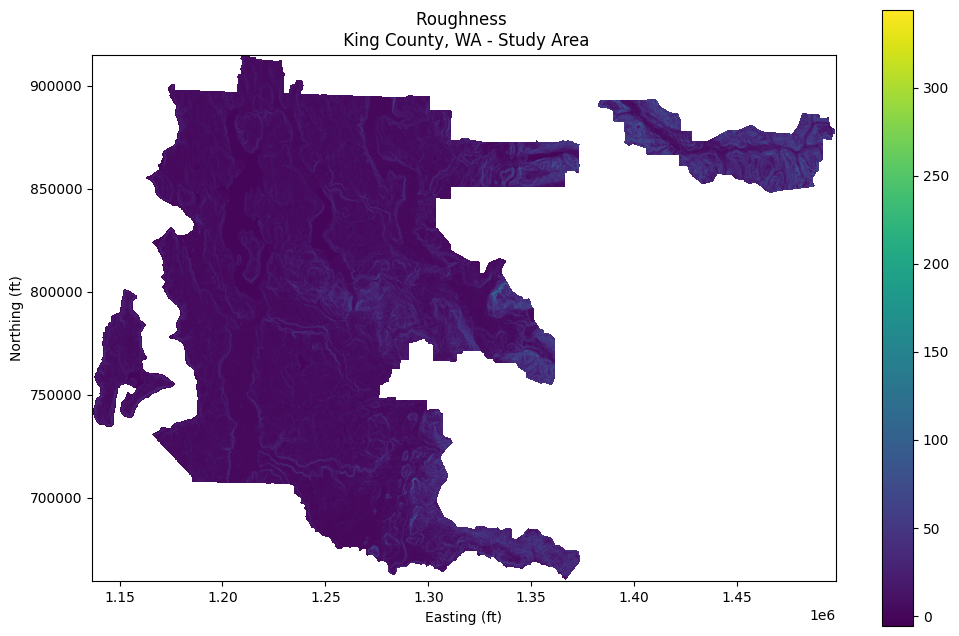

In [ ]:
# Sanity check
f, ax = plt.subplots(figsize=(12,8))
map = ax.imshow(ma, extent=ma_extent, cmap = 'viridis')
plt.title('Roughness \n King County, WA - Study Area')
plt.xlabel('Easting (ft)')
plt.ylabel('Northing (ft)')
f.colorbar(map, ax=ax);

In [ ]:
# Define relevant stats for our sampling
stats = ['min', 'max', 'mean', 'std']

# rasterstats
gdf_zonal_stats = rasterstats.zonal_stats(centroid_buff_gdf, ma, affine = ma_transform, nodata=src.nodata, stats=stats)

# sanity check fpr zonal stats
gdf_zonal_stats[0:5]

[{'min': 3.2442197799682617,
  'max': 39.711238861083984,
  'mean': 18.773749215262278,
  'std': 8.939350780781462},
 {'min': 17.112117767333984,
  'max': 32.82430648803711,
  'mean': 24.181767054966517,
  'std': 3.681896462658613},
 {'min': 5.90960693359375,
  'max': 27.99576759338379,
  'mean': 18.422394851158405,
  'std': 6.574038579048274},
 {'min': 7.192145347595215,
  'max': 37.36431884765625,
  'mean': 21.28656005859375,
  'std': 8.332987746991282},
 {'min': 3.911461353302002,
  'max': 37.36431884765625,
  'mean': 18.165190520109952,
  'std': 8.389120736871988}]

In [ ]:
# creating a DataFrame to store values in the original inventory data
zonal_stats_df = pd.DataFrame(gdf_zonal_stats, index = centroid_buff_gdf.index)
zonal_stats_df.head()
print(zonal_stats_df.shape)

(2670, 4)


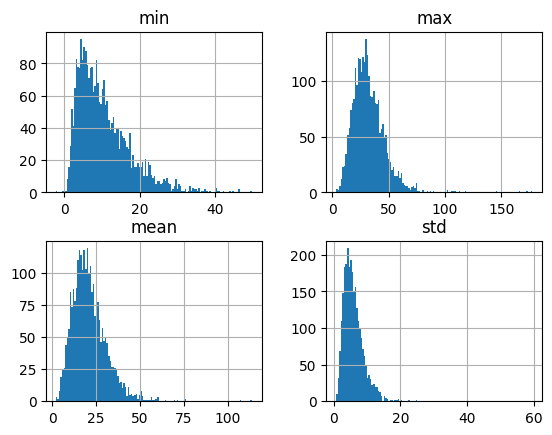

In [ ]:
# join two dataframes
gdf_concat = pd.concat([gdf_concat, zonal_stats_df], axis=1)

# Quick plot
gdf_concat[['min','max', 'mean', 'std']].hist(bins=128);

In [ ]:
# changing names for better practices:
gdf_concat = gdf_concat.rename(columns={'min':'min_rough', 'max':'max_rough', 'mean':'mean_rough', 'std':'std_rough'})

# last sanity check of the dataframe:
gdf_concat.head(2)

,OBJECTID,soruce_length,source_area,landslide_ID,deposit_area,CONFIDENCE,MATERIAL,SLOPE_DEG,HS_HEIGHT,FAIL_DEPTH,...,geometry,centroid,min_elev,max_elev,mean_elev,std_elev,min_rough,max_rough,mean_rough,std_rough
0,1,3851.588931,147260.070502,5600,531934.562792,moderate,Earth or debris,31,72,62,...,"POLYGON ((1175895.407 901572.922, 1175950.408 ...",POINT (1176081.331 900702.237),42.0,78.0,64.464286,11.004811,3.244220,39.711239,18.773749,8.939351
1,2,478.577643,7375.893616,5601,13973.308516,low,Earth or debris,31,40,34,...,"POLYGON ((1175850.769 899952.492, 1175859.171 ...",POINT (1175912.121 899921.581),21.0,70.0,46.607143,14.056872,17.112118,32.824306,24.181767,3.681896


In [ ]:
gdf_concat.to_csv(main_path + '/inventory_with_elev_rough.csv')

## 3. Sample Slope

In [ ]:
# raster reprojection function
def rio_reproj_write(src, proj_fn, dst_crs, driver='HFA'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

In [ ]:
# Opening the raster data with rasterio
raster_path = main_path + '/slope_wa/wa_slope.tif' # write path of raster data - DEM
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data - DEM_reproj
rio_reproj_write(src, proj_fn, proj)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
File exists:  /content/drive/MyDrive/MLGeo23_Landslide_FinalProject/data/slop

In [ ]:
# open raster and clip
raster_path = main_path + '/slope_wa/wa_slope_reproj.tif' # change the path
src = rio.open(raster_path)

# clip for KC study area
geom = study_area.geometry
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(src, geom, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

# Sanity check
f, ax = plt.subplots(figsize=(12,8))
map = ax.imshow(ma, extent=ma_extent, cmap = 'viridis')
plt.title('Roughness \n King County, WA - Study Area')
plt.xlabel('Easting (ft)')
plt.ylabel('Northing (ft)')
f.colorbar(map, ax=ax);

ValueError: ignored

## 4. Water Table

In [13]:

geom = study_area.geometry
geom_gdf = gpd.GeoSeries(geom)
geom_gdf

0    POLYGON Z ((1152604.999 801484.000 0.000, 1152...
1    POLYGON Z ((1490263.525 886220.999 0.000, 1490...
2    POLYGON Z ((1301441.001 773653.001 0.000, 1301...
Name: geometry, dtype: geometry

In [19]:
# open raster and clip
raster_path = main_path + '/water_table/wtd_north_america_CF_reproj.tif' # change the path
src = rio.open(raster_path)

# clip for KC study area

rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(src, geom_gdf, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

# Sanity check
f, ax = plt.subplots(figsize=(12,8))
map = ax.imshow(ma, extent=ma_extent, cmap = 'viridis')
plt.title('Slope \n King County, WA - Study Area')
plt.xlabel('Easting (ft)')
plt.ylabel('Northing (ft)')
f.colorbar(map, ax=ax);

ValueError: ignored

In [ ]:
# Geometry area and centroid // Adding columns
gdf['centroid'] = gdf.geometry.centroid
centroid = gdf['centroid']

#define buffer
buff_dist = src.res[0]*3

# create new geodataframe
centroid_buff = centroid.buffer(buff_dist)

centroid_buff_gdf = gpd.GeoDataFrame(centroid.copy(), geometry=centroid_buff)

## 3. Raster Data Caracterization